In this part, the goal is to create new representations for features,

In [48]:
import pandas as pd

In [49]:
data = pd.read_csv('day-pre.csv')

In [50]:
data.columns

Index(['date', 'season', 'year', 'month', 'holiday', 'weekday', 'workingday',
       'weather', 'temp', 'atemp', 'humidity', 'windspeed', 'casual',
       'registered', 'total_count', 'total_count_smoothed_kalman'],
      dtype='object')

In [51]:
data['date'] = pd.to_datetime(data['date'])
data['season'] = data.season.astype('category')
data['month'] = data.month.astype('category')
data['holiday'] = data.holiday.astype('category')
data['weekday'] = data.weekday.astype('category')
data['workingday'] = data.workingday.astype('category')
data['weather'] = data.weather.astype('category')

In [52]:
data.weather.replace((1,2,3,4), ('Clear, Few clouds, Partly cloudy, Partly cloudy','Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist','Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds','Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog'), inplace=True)


In [53]:
data['weather']

0      Mist + Cloudy, Mist + Broken clouds, Mist + Fe...
1      Mist + Cloudy, Mist + Broken clouds, Mist + Fe...
2        Clear, Few clouds, Partly cloudy, Partly cloudy
3        Clear, Few clouds, Partly cloudy, Partly cloudy
4        Clear, Few clouds, Partly cloudy, Partly cloudy
                             ...                        
671    Mist + Cloudy, Mist + Broken clouds, Mist + Fe...
672    Mist + Cloudy, Mist + Broken clouds, Mist + Fe...
673    Mist + Cloudy, Mist + Broken clouds, Mist + Fe...
674      Clear, Few clouds, Partly cloudy, Partly cloudy
675    Mist + Cloudy, Mist + Broken clouds, Mist + Fe...
Name: weather, Length: 676, dtype: category
Categories (3, object): ['Clear, Few clouds, Partly cloudy, Partly cloudy', 'Mist + Cloudy, Mist + Broken clouds, Mist + F..., 'Light Snow, Light Rain + Thunderstorm + Scatt...]

##### Correlation based Feature selection

In [54]:
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns

numerical_data = data.select_dtypes(include=[np.number])
numerical_data.drop(['year'],inplace=True, axis=1)

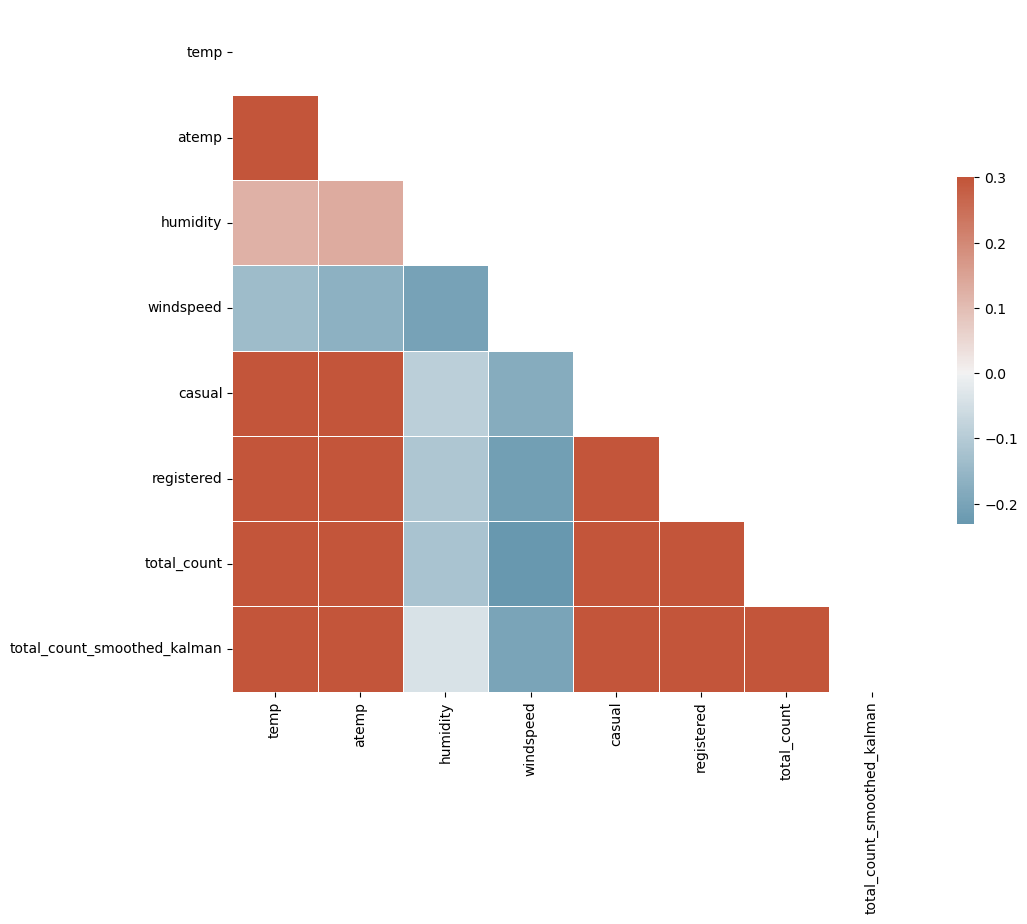

In [55]:


corr = numerical_data.corr()

mask = np.triu(np.ones_like(corr, dtype=bool))

f, ax = plt.subplots(figsize=(11, 9))

cmap = sns.diverging_palette(230, 20, as_cmap=True)

sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

plt.show()


In [56]:
## ici le feature non important est humidy pas windspeed

Les features a enlever : 
- windspeed : tres faible correlattion avec total count
- atemp : une sorte de redondance avec temp 
- date : vaut mieux qu'elle soit fragmentee en plusieurs colonnes
On aurait pu croire ue weekday et working day contiennent des informations redondante sauf que non, il se peut qu'un working day soit un weekend et vice versa.

In [57]:
nd = numerical_data.copy()

In [58]:
nd.columns

Index(['temp', 'atemp', 'humidity', 'windspeed', 'casual', 'registered',
       'total_count', 'total_count_smoothed_kalman'],
      dtype='object')

In [59]:
def select_features(df, target, threshold):
    correlations = df.corr()[target]
    selected_features = correlations[correlations.abs() > threshold].index.tolist()
    selected_features.remove(target)  
    return selected_features

selected_features = select_features(numerical_data, 'total_count', 0.15)
print("Selected features:", selected_features)


Selected features: ['temp', 'atemp', 'windspeed', 'casual', 'registered', 'total_count_smoothed_kalman']


In [60]:
### on fragmente date
### Fragmentation de la date
# Ceci va ecraser month et year, et tant mieux 
data['year'] = data['date'].dt.year
data['month'] = data['date'].dt.month
data['day'] = data['date'].dt.day

In [61]:
data.columns

Index(['date', 'season', 'year', 'month', 'holiday', 'weekday', 'workingday',
       'weather', 'temp', 'atemp', 'humidity', 'windspeed', 'casual',
       'registered', 'total_count', 'total_count_smoothed_kalman', 'day'],
      dtype='object')

In [62]:
df_oh = data.drop(['date','atemp'], axis=1)
df_oh['humidity_windspeed'] = data['humidity'] * data['windspeed']
df_oh = df_oh.drop(['humidity','windspeed'], axis=1)
df_oh.head(-5)

,season,year,month,holiday,weekday,workingday,weather,temp,casual,registered,total_count,total_count_smoothed_kalman,day,humidity_windspeed
0,1,2011,1,0,6,0,"Mist + Cloudy, Mist + Broken clouds, Mist + Fe...",0.344167,331,654,985,622.030424,1,0.129293
1,1,2011,1,0,0,0,"Mist + Cloudy, Mist + Broken clouds, Mist + Fe...",0.363478,131,670,801,881.091273,2,0.173005
2,1,2011,1,0,1,1,"Clear, Few clouds, Partly cloudy, Partly cloudy",0.196364,120,1229,1349,1220.243394,3,0.108579
3,1,2011,1,0,2,1,"Clear, Few clouds, Partly cloudy, Partly cloudy",0.200000,108,1454,1562,1430.638910,4,0.094644
4,1,2011,1,0,3,1,"Clear, Few clouds, Partly cloudy, Partly cloudy",0.226957,82,1518,1600,1509.673336,5,0.081667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
666,1,2012,12,0,5,1,"Mist + Cloudy, Mist + Broken clouds, Mist + Fe...",0.326667,221,3402,3623,3331.386084,21,0.208407
667,1,2012,12,0,0,0,"Clear, Few clouds, Partly cloudy, Partly cloudy",0.245833,408,1379,1787,1786.930255,23,0.068593
668,1,2012,12,0,1,1,"Mist + Cloudy, Mist + Broken clouds, Mist + Fe...",0.231304,174,746,920,1284.685320,24,0.061113
669,1,2012,12,1,2,0,"Mist + Cloudy, Mist + Broken clouds, Mist + Fe...",0.291304,440,573,1013,1147.125704,25,0.123977


Une autre alternative de l'action de suppression de l'attribut windspeed car il a une faible correlation avec count,  atemp car c'est pratiquement la meme chose que temp, aurait ete de creer un attribut d'interaction qui represente le produit de ces deux la.

Codification des variables categorielle : One hot encoding

For one hot encoding, get_dummies  a bad idea because it created instances based on values on you dataset.

Maintenant, toujours dans le one hot encoding, nous allons travailler particulierement sur la colonne weather, chaque instance contient plusieurs etat donc on va encoder a chaud chaque etat.

In [63]:
import pandas as pd
import numpy as np

def custom_one_hot_encoder(df, cols, min_values, max_values):
    df_copy = df.copy()
    for col in cols:
        for i in range(min_values[col], max_values[col]+1):
            df_copy[col + '_' + str(i)] = np.where(df_copy[col] == i, 1, 0)

    df_copy = df_copy.drop(cols, axis=1)

    return df_copy

cols = ['season','month','weekday']
min_values = {'season': 1, 'month': 1, 'weekday': 0}
max_values = {'season': 4, 'month': 12, 'weekday': 6}

df_final = custom_one_hot_encoder(df_oh, cols, min_values, max_values)
df_final.columns

Index(['year', 'holiday', 'workingday', 'weather', 'temp', 'casual',
       'registered', 'total_count', 'total_count_smoothed_kalman', 'day',
       'humidity_windspeed', 'season_1', 'season_2', 'season_3', 'season_4',
       'month_1', 'month_2', 'month_3', 'month_4', 'month_5', 'month_6',
       'month_7', 'month_8', 'month_9', 'month_10', 'month_11', 'month_12',
       'weekday_0', 'weekday_1', 'weekday_2', 'weekday_3', 'weekday_4',
       'weekday_5', 'weekday_6'],
      dtype='object')

In [64]:
df_oh = df_final.copy()

In [65]:
weather_states = ['Clear', 'Few clouds', 'Partly cloudy', 'Mist', 'Cloudy', 'Broken clouds', 'Light Snow', 'Light Rain', 'Thunderstorm', 'Scattered clouds', 'Heavy Rain', 'Ice Pallets', 'Snow', 'Fog']
for state in weather_states:
    df_oh[state] = df_oh['weather'].apply(lambda x: 1 if state in x else 0)

df_oh = df_oh.drop(columns=['weather'])

In [66]:
df_oh.columns

Index(['year', 'holiday', 'workingday', 'temp', 'casual', 'registered',
       'total_count', 'total_count_smoothed_kalman', 'day',
       'humidity_windspeed', 'season_1', 'season_2', 'season_3', 'season_4',
       'month_1', 'month_2', 'month_3', 'month_4', 'month_5', 'month_6',
       'month_7', 'month_8', 'month_9', 'month_10', 'month_11', 'month_12',
       'weekday_0', 'weekday_1', 'weekday_2', 'weekday_3', 'weekday_4',
       'weekday_5', 'weekday_6', 'Clear', 'Few clouds', 'Partly cloudy',
       'Mist', 'Cloudy', 'Broken clouds', 'Light Snow', 'Light Rain',
       'Thunderstorm', 'Scattered clouds', 'Heavy Rain', 'Ice Pallets', 'Snow',
       'Fog'],
      dtype='object')

In [67]:
ordered_cols = ['day','month_1', 'month_2', 'month_3', 'month_4', 'month_5', 'month_6', 
                'month_7', 'month_8', 'month_9', 'month_10', 'month_11', 'month_12', 
                'year','weekday_0', 'weekday_1', 'weekday_2', 'weekday_3', 'weekday_4', 
                'weekday_5', 'weekday_6', 'holiday', 'workingday', 'temp', 'humidity_windspeed', 
                'season_1', 'season_2', 'season_3', 'season_4', 
                'Clear', 'Few clouds', 'Partly cloudy', 
                'Mist', 'Cloudy', 'Broken clouds', 'Light Snow', 'Light Rain', 
                'Thunderstorm', 'Scattered clouds', 'Heavy Rain', 'Ice Pallets', 'Snow', 'Fog',
                'casual','registered', 'total_count', 'total_count_smoothed_kalman']

df_final = df_oh[ordered_cols]
df_final.head()

,day,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,...,Thunderstorm,Scattered clouds,Heavy Rain,Ice Pallets,Snow,Fog,casual,registered,total_count,total_count_smoothed_kalman
0,1,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,331,654,985,622.030424
1,2,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,131,670,801,881.091273
2,3,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,120,1229,1349,1220.243394
3,4,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,108,1454,1562,1430.638910
4,5,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,82,1518,1600,1509.673336


In [68]:
## Now we check relation betweem weekdays and workingday 

weekday_mask = (df_final['weekday_0'] == 1) | (df_final['weekday_1'] == 1) | (df_final['weekday_2'] == 1) | (df_final['weekday_3'] == 1) | (df_final['weekday_4'] == 1 | (df_final['weekday_5'] == 1)) | (df_final['weekday_6'] == 1)

workingday_mask = df_final['workingday'] == 1

common_days = df_final[weekday_mask & workingday_mask]

weekday_columns = ['weekday_0', 'weekday_1', 'weekday_2', 'weekday_3', 'weekday_4', 'weekday_5', 'weekday_6']

common_days_weekdays = common_days[weekday_columns]

common_days[weekday_columns].nunique()

weekday_0    1
weekday_1    2
weekday_2    2
weekday_3    2
weekday_4    2
weekday_5    1
weekday_6    1
dtype: int64

In [69]:
# so working day can be any day not just weekend so we do not take off the feature.

In [70]:
df_final.to_csv('day_final.csv', index=False)